### Notebook to create a CalibratedImage object test methods

Import statements

In [1]:
import os
import numpy as np
from astropy.io import fits
import pylab as plt
import logging
from ConfigParser import ConfigParser

Choose a PTF image file and a SExtractor catalog file to create a image object. Here there is a sample PTF image obtained from the IRSA website (http://irsa.ipac.caltech.edu/applications/ptf/) along with the SExtractor catalog file.

In [2]:
image_file = 'etc/PTF_200907224952_i_p_scie_t115307_u012001395_f02_p001572_c05_ra3.5166_dec-23.1821_asec500.fits'
se_cat_file= 'etc/PTF_200907224952_c_p_scie_t115307_u012001395_f02_p001572_c05.ctlg'

The image looks like the following

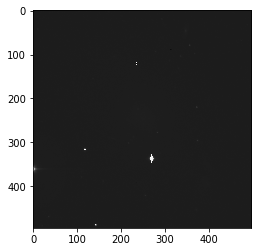

In [3]:
%matplotlib inline
image_data = fits.getdata(image_file)
plt.imshow(image_data, cmap='gray')
#plt.show()

- Create a logger object to write logs into. By default it is created in the *etc* directory.
- Also point to a config file. The script write_config.py will write one in the *etc* directory

In [4]:
run config_writer.py

In [5]:
#log_fmt = '%(asctime) -- %(levelname) : %(message)'
logfile = os.path.join(os.getcwdu(), 'etc/fakes.log')
confile = os.path.join(os.getcwdu(), 'etc/conf.ini')
logging.basicConfig(filename = logfile, filemode = 'w', level = logging.DEBUG)
logger  = logging.getLogger()
config  = ConfigParser()
config.read(confile)

[u'/home/deep/github/ztf_fakes/ztf_fakes/etc/conf.ini']

The logging.basicConfig(...) might give a deprecation warning for Python3 about the way the filename is passed. It asks to supply unicode strings. But this is fine for us.

#### We can create the CalibratedImage object

In [6]:
from image import CalibratedImage

img_obj = CalibratedImage(image_file, se_cat_file, config=config, logger=logger)

#### Test out the methods
- There are many method names ending in _Check_. Each returns a boolean array (a mask) which can be used anytime later to pull out the data from the SExtractor catalog.
- Each check reads for a max and min value from the config file, which are supposed to be the upper and lower cuts  of the check. For example _starElgnCheck()_ filters the objects based on the cuts applied.
- If the upper and lower values are not supplied (no value in the config file), it is assumed that bound is not to be supplied (see config file).
- Stars and Galaxies have separate checks, since the constraint put on each might be different.

In [7]:
check1 = img_obj.starFWHMCheck()
check2 = img_obj.galMagCheck()
print check1
print np.sum(check2)

[False False  True ...,  True  True  True]
2070


#### Perform all the checks on the stars and print the filtered SE catalog


In [8]:
img_obj.giveStarsTable()

id,zp,flags,fwhm,flux,mag,x,y,bkgnd,elgn,x2,y2,xy,theta,A,B,class_st
,,,pix,ct,mag,pix,pix,ct,,pix2,pix2,pix2,deg,pix,pix,
int32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float32
22,27.5167,0,2.95301,1459.73,-7.91068,711.444,24.3477,2438.99,1.32706,0.941225525005,0.865935112539,0.246210965702,40.6535,1.07362,0.809017,0.90045
44,27.517,0,2.89184,1071.14,-7.57462,897.855,67.709,2433.9,1.3207,0.496790410268,0.74935340492,-0.112278249221,-69.1797,0.889972,0.673865,0.612547
45,27.5173,0,3.13156,1016.11,-7.51735,826.305,67.8023,2431.83,1.34814,0.7269252271,0.50169815735,0.138158170808,25.4082,0.890254,0.660357,0.614655
57,27.5162,0,3.5409,2287.87,-8.39858,1569.63,94.0704,2433.09,1.55608,1.26295123053,0.552445807536,0.126482693231,9.79878,1.13349,0.728424,0.737999
77,27.5261,0,2.42015,1050.07,-7.55304,1858.37,137.778,2454.3,1.25024,0.66673459743,0.866324377903,-0.135648407044,-63.1707,0.966919,0.773386,0.680467
87,27.5138,0,3.3882,1595.3,-8.0071,1041.37,147.636,2430.93,1.28195,1.20009557792,0.905154890065,0.209513931202,27.4297,1.14404,0.892421,0.840166
132,27.5114,0,3.04797,1632.04,-8.03183,1051.8,230.257,2428.82,1.27277,1.16673877856,0.768578727119,0.113109237427,14.8017,1.0939,0.859471,0.830563
143,27.5282,24,5.13062,1729.66,-8.0949,2046.63,255.242,2462.9,1.28629,0.883974233205,1.1865430969,0.205605378919,63.1728,1.13601,0.883172,0.921066
